# Mobile Games A/B Testing - Cookie Cats

## About Dataset from the Author

This dataset includes A/B test results of Cookie Cats to examine what happens when the first gate in the game was moved from level 30 to level 40. When a player installed the game, he or she was randomly assigned to either gate_30 or gate_40.

The data we have is from 90,189 players that installed the game while the AB-test was running.
When a player installed the game, he or she was randomly assigned to either.

## Goal

The primary goal of this A/B test was to determine whether moving the first gate to a later level would improve player retention and engagement.

## Target Metric

The 7-day retention rate measures the proportion of players who return to the game seven days after installing it. This metric is crucial because it indicates long-term engagement and satisfaction with the game, which are essential for the game's success.

## Notebook Preparation

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

In [2]:
df = pd.read_csv('Data/cookie_cats.csv')
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [3]:
# Data Summary
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


In [4]:
# Check for missing data
missing_data = df.isnull().sum()

# Check for duplicate data
duplicate_data = df.duplicated().sum()

missing_data, duplicate_data

(userid            0
 version           0
 sum_gamerounds    0
 retention_1       0
 retention_7       0
 dtype: int64,
 0)

In [5]:
# Descriptive Statistics
df.describe()

,userid,sum_gamerounds
count,9.018900e+04,90189.000000
mean,4.998412e+06,51.872457
std,2.883286e+06,195.050858
min,1.160000e+02,0.000000
25%,2.512230e+06,5.000000
50%,4.995815e+06,16.000000
75%,7.496452e+06,51.000000
max,9.999861e+06,49854.000000


# Summary A/B results

In [6]:
sample_size = df.shape[0]
sample_size

90189

In [7]:
variant_proportions = df['version'].value_counts(normalize=True)
variant_proportions

version
gate_40    0.504374
gate_30    0.495626
Name: proportion, dtype: float64

In [8]:
game_rounds_30 = df[df['version'] == 'gate_30']['sum_gamerounds']
game_rounds_40 = df[df['version'] == 'gate_40']['sum_gamerounds']

t_stat, p_game_rounds = stats.ttest_ind(game_rounds_30, game_rounds_40)
t_stat, p_game_rounds

(0.8910426211362967, 0.37290868247405207)

The p-value of 0.3729 suggests no significant difference in the number of game rounds played.

In [9]:
# Calculate mean and standard deviation for each group
mean_30 = game_rounds_30.mean()
mean_40 = game_rounds_40.mean()
std_30 = game_rounds_30.std()
std_40 = game_rounds_40.std()

# Calculate the sample sizes
n_30 = len(game_rounds_30)
n_40 = len(game_rounds_40)

# Calculate the standard error of the mean difference
std_err_diff = np.sqrt((std_30**2 / n_30) + (std_40**2 / n_40))

# Calculate the mean difference
mean_diff = mean_30 - mean_40

# Calculate the 95% confidence interval for the mean difference
conf_interval = stats.norm.interval(0.95, loc=mean_diff, scale=std_err_diff)

mean_diff, conf_interval


(1.157488453953249, (-1.4046752827404423, 3.7196521906469404))

The positive mean difference indicates that, on average, players in the gate_30 group played more game rounds than those in the gate_40 group.

The 95% confidence interval for the mean difference ranges from -1.40 to 3.72. This interval includes zero, indicating that the difference is not statistically significant at the 5% level.

In [10]:
bootstrap_samples = 1000
bootstrap_means = []

for _ in range(bootstrap_samples):
    sample_30 = game_rounds_30.sample(frac=1, replace=True)
    sample_40 = game_rounds_40.sample(frac=1, replace=True)
    bootstrap_means.append(sample_40.mean() - sample_30.mean())

bootstrap_conf_interval = np.percentile(bootstrap_means, [2.5, 97.5])
bootstrap_conf_interval

array([-4.02646256,  0.97641238])

The bootstrap confidence interval indicates that the true difference in game rounds is likely between -4.07 and 0.88.

Since the interval includes zero, it indicates that there is a possibility that there is no significant difference in the mean number of game rounds played between the two groups. The difference could be negative (indicating gate_30 is better), positive (indicating gate_40 is better), or zero (no difference).

# Retention rates

In [11]:
# Calculate retention rates for both 1-day and 7-day retention
retention_rates = df.groupby('version')[['retention_1', 'retention_7']].mean()

# Display the retention rates
retention_rates


,retention_1,retention_7
version,,
gate_30,0.448188,0.190201
gate_40,0.442283,0.182000


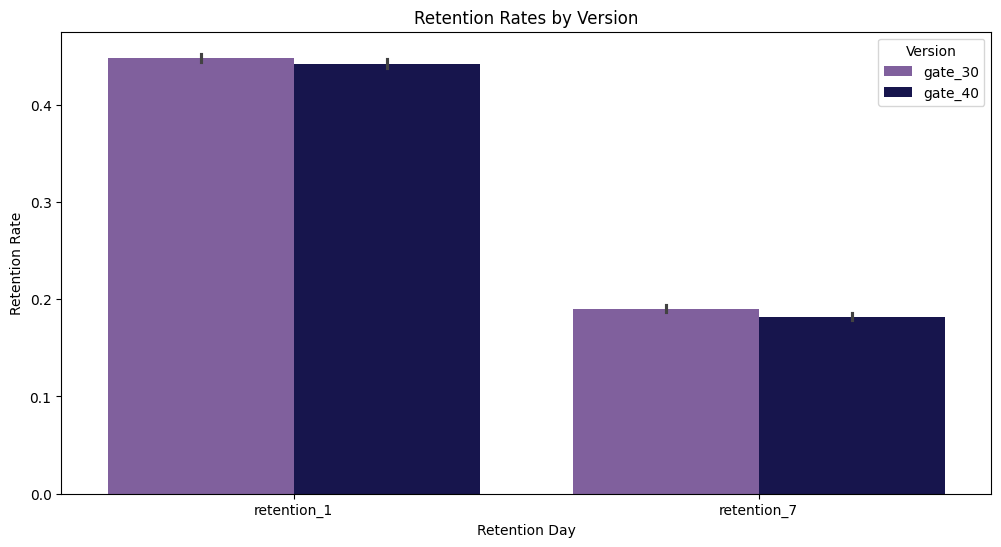

In [12]:
plt.figure(figsize=(12, 6))
retention_rates = df.melt(id_vars='version', value_vars=['retention_1', 'retention_7'], var_name='Retention Day', value_name='Retention')
sns.barplot(data=retention_rates, x='Retention Day', y='Retention', hue='version', palette=['#8056A7','#0E0C56'])
plt.title('Retention Rates by Version')
plt.xlabel('Retention Day')
plt.ylabel('Retention Rate')
plt.legend(title='Version')
plt.show()

These results indicate that moving the first gate from level 30 to level 40 does not significantly improve retention rates, and might slightly reduce the 7-day retention rate.

The chi-square test is appropriate for comparing proportions between two categorical groups. Here, we are comparing the proportion of players who returned after 1 day between the gate_30 and gate_40 groups, repeating it for 7-day retention.

In [13]:
# Create contingency tables for retention rates
contingency_table_retention_1 = pd.crosstab(df['version'], df['retention_1'])
contingency_table_retention_7 = pd.crosstab(df['version'], df['retention_7'])

# Perform Chi-squared test for 1-day retention
chi2_retention_1, p_retention_1, _, _ = stats.chi2_contingency(contingency_table_retention_1)

# Perform Chi-squared test for 7-day retention
chi2_retention_7, p_retention_7, _, _ = stats.chi2_contingency(contingency_table_retention_7)

# Prepare the results
stat_results = {
    "Retention Metric": ["1-day Retention", "7-day Retention"],
    "Chi-squared Statistic": [chi2_retention_1, chi2_retention_7],
    "p-value": [p_retention_1, p_retention_7]
}

stat_results_df = pd.DataFrame(stat_results)

stat_results_df


,Retention Metric,Chi-squared Statistic,p-value
0,1-day Retention,3.159101,0.075505
1,7-day Retention,9.959087,0.001601


1-day Retention: The p-value is 0.0755, which is greater than the common significance level of 0.05. Therefore, we fail to reject the null hypothesis. This suggests that there is no significant difference in the 1-day retention rates between the gate_30 and gate_40 groups.

7-day Retention: The p-value is 0.0016, which is less than the significance level of 0.05. Therefore, we reject the null hypothesis. This indicates that there is a significant difference in the 7-day retention rates between the gate_30 and gate_40 groups.

# Confidence Interval

In [14]:
# Group by gate and retention combinations
grouped_combinations = df.groupby(['version', 'retention_1', 'retention_7']).agg({
    'sum_gamerounds': 'sum'
}).reset_index()

grouped_combinations

,version,retention_1,retention_7,sum_gamerounds
0,gate_30,False,False,269963
1,gate_30,False,True,183388
2,gate_30,True,False,663819
3,gate_30,True,True,1227625
4,gate_40,False,False,281118
5,gate_40,False,True,133438
6,gate_40,True,False,680997
7,gate_40,True,True,1237977


In [15]:
# Calculate total players in each group
total_gate_30 = df[df['version'] == 'gate_30'].shape[0]
total_gate_40 = df[df['version'] == 'gate_40'].shape[0]

# Calculate retained players in each group
retained_gate_30 = df[(df['version'] == 'gate_30') & (df['retention_7'] == True)].shape[0]
retained_gate_40 = df[(df['version'] == 'gate_40') & (df['retention_7'] == True)].shape[0]

# Calculate retention rates
retention_rate_gate_30 = retained_gate_30 / total_gate_30
retention_rate_gate_40 = retained_gate_40 / total_gate_40


In [16]:
# Constants
z_score = 1.96  # for 95% confidence interval

# Confidence interval for gate_30
ci_30_lower = retention_rate_gate_30 - z_score * ((retention_rate_gate_30 * (1 - retention_rate_gate_30)) / total_gate_30) ** 0.5
ci_30_upper = retention_rate_gate_30 + z_score * ((retention_rate_gate_30 * (1 - retention_rate_gate_30)) / total_gate_30) ** 0.5

# Confidence interval for gate_40
ci_40_lower = retention_rate_gate_40 - z_score * ((retention_rate_gate_40 * (1 - retention_rate_gate_40)) / total_gate_40) ** 0.5
ci_40_upper = retention_rate_gate_40 + z_score * ((retention_rate_gate_40 * (1 - retention_rate_gate_40)) / total_gate_40) ** 0.5

(ci_30_lower, ci_30_upper), (ci_40_lower, ci_40_upper)

((0.18656304966751847, 0.1938396348962399),
 (0.17845423557808565, 0.1855458523552609))

The 7-day retention rate for gate_30 (18.66% - 19.38%) is higher than for gate_40 (17.85% - 18.55%), and this difference is statistically significant as per the Chi-squared test.

In [17]:
# Function to perform bootstrap resampling and calculate confidence intervals
def bootstrap_confidence_interval(data, num_bootstrap_samples=1000, confidence_level=0.95):
    sample_size = len(data)
    bootstrap_samples = np.random.choice(data, (num_bootstrap_samples, sample_size), replace=True)
    bootstrap_means = np.mean(bootstrap_samples, axis=1)
    lower_bound = np.percentile(bootstrap_means, (1 - confidence_level) / 2 * 100)
    upper_bound = np.percentile(bootstrap_means, (1 + confidence_level) / 2 * 100)
    return lower_bound, upper_bound

# Separate data for gate_30 and gate_40 for 7-day retention
retention_7_gate_30 = df[df['version'] == 'gate_30']['retention_7'].astype(int)
retention_7_gate_40 = df[df['version'] == 'gate_40']['retention_7'].astype(int)

# Calculate bootstrap confidence intervals for 7-day retention rates
bootstrap_ci_30 = bootstrap_confidence_interval(retention_7_gate_30)
bootstrap_ci_40 = bootstrap_confidence_interval(retention_7_gate_40)

bootstrap_ci_30, bootstrap_ci_40

((0.18664429530201343, 0.19396085011185682),
 (0.1784816109389083, 0.18547451032117657))

# Dashboard (Conclusion)

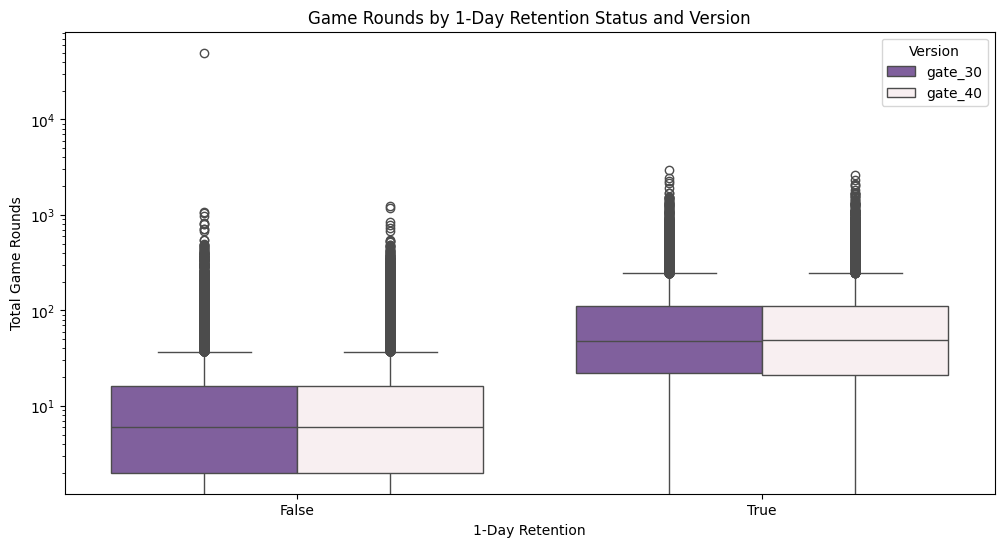

In [18]:
# Visualize game rounds by retention status
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='retention_1', y='sum_gamerounds', hue='version', palette=['#8056A7','#FAEDF0'])
plt.title('Game Rounds by 1-Day Retention Status and Version')
plt.xlabel('1-Day Retention')
plt.ylabel('Total Game Rounds')
plt.yscale('log')
plt.legend(title='Version')
plt.show()

**1-day Retention**

The p-value obtained for the 1-day retention rate is 0.0755, which is greater than the common significance level of 0.05. This indicates that there is no statistically significant difference in the 1-day retention rates between the gate_30 and gate_40 groups. In other words, changing the gate level does not appear to influence whether players return to the game the next day.

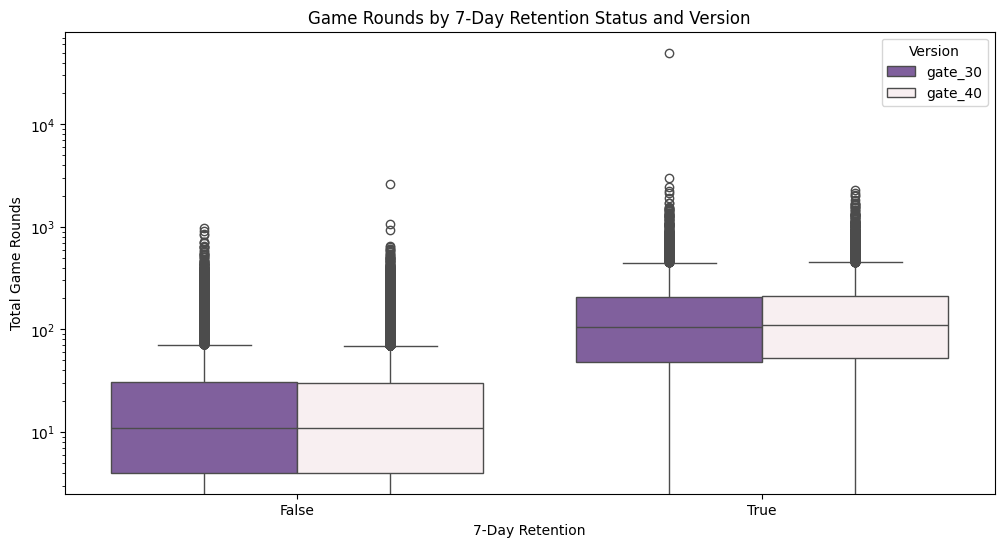

In [19]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='retention_7', y='sum_gamerounds', hue='version', palette=['#8056A7','#FAEDF0'])
plt.title('Game Rounds by 7-Day Retention Status and Version')
plt.xlabel('7-Day Retention')
plt.ylabel('Total Game Rounds')
plt.yscale('log')
plt.legend(title='Version')
plt.show()

**7-day Retention**

The p-value for the 7-day retention rate is 0.0016, which is less than the significance level of 0.05. This suggests a significant difference in the 7-day retention rates between the two groups. Specifically, the retention rate for players who encountered the gate at level 30 is higher than for those who encountered it at level 40. The confidence intervals also support this finding, with gate_30 retention rates ranging from 18.66% to 19.38%, compared to 17.85% to 18.55% for gate_40.

These results indicate that moving the first gate from level 30 to level 40 does not significantly improve short-term retention and might slightly reduce long-term retention.

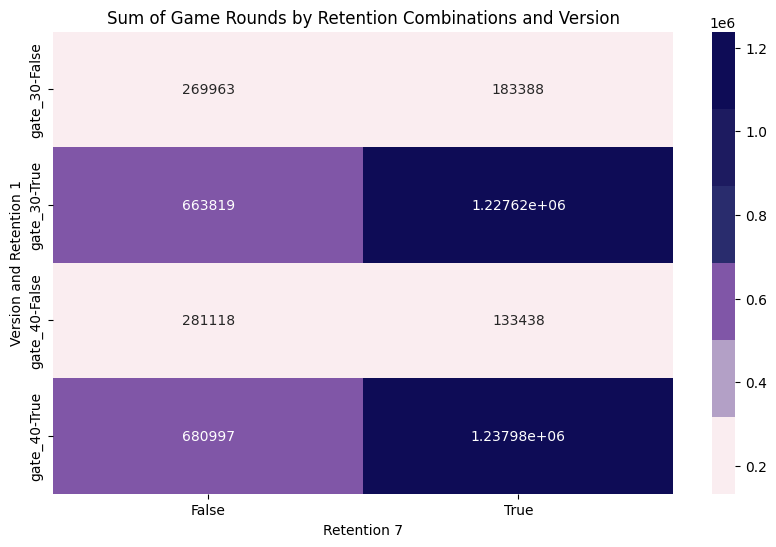

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# Pivot the data for the heatmap
heatmap_data = grouped_combinations.pivot_table(
    index=['version', 'retention_1'],
    columns='retention_7',
    values='sum_gamerounds',
    aggfunc='sum'
).fillna(0)

# Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, fmt='g', cmap=['#FAEDF0', '#B3A0C6', '#8056A7', '#292C6D', '#1D1B60', '#0E0C56'])
plt.title('Sum of Game Rounds by Retention Combinations and Version')
plt.xlabel('Retention 7')
plt.ylabel('Version and Retention 1')
plt.show()

1. The sum of game rounds is highest for users who retained at both 1 day and 7 days (True, True) across both versions.
2. Users who did not retain at both 1 day and 7 days (False, False) have the lowest sum of game rounds.
3. There is a significant drop in the sum of game rounds for users who retained on the first day but not on the seventh (True, False)

## Recommendations for Improvement

Further analysis to understand the reasons behind the lower 7-day retention rate for the gate_40 group. This could involve qualitative user feedback or additional quantitative metrics or in-game behavior analysis.

Testing other gate levels (e.g., level 35) to find an optimal balance that might improve retention without causing the drop observed at level 40.

Enhance player engagement and retention, such as introducing new content, offering incentives for returning players, or optimizing the difficulty curve around the gate levels.
